# Assignment 3: Clustering California Housing with K-means

### CS 4774 Machine Learning - Department of Computer Science - University of Virginia
"Tonight, more than 130,000 Californians will go to sleep homeless. That’s enough to fill Dodger Stadium, AT&T Park and Petco Park. The biggest culprit is rising housing costs. From 2000 to 2014, median rent in California increased by more than one-third, while real incomes for renters fell by 7 percent. Today, 1.5 million Californians spend more than half their income on housing. This crisis threatens not just low-income families but our entire economy, driving businesses to relocate to states in which their employees can afford to live. - **Business Insider, Sep 2018.**"

![Half of the homes in San Franciso is now one million or above](https://amp.businessinsider.com/images/573de0b88d3eaea27198a55d-960-480.jpg)

In this assignment, you will attempt to cluster the California Housing by implementing and analyzing the k-means algorithm to the data. K-Means is one of the most popular clustering algorithms. K-means stores k-centroids that it uses to define clusters. A point is considered to be in a particular cluster if it is closer to that cluster's centroid than any other centroid. For references, you may refer to my lecture 9 or Chapter 2 of the textbook if you need additional sample codes to help with your assignment. For deliverables, you must write code in Python and submit this Jupyter Notebook file (.ipynb) to earn a total of 100 pts. You will gain points depending on how you perform in the following sections.

**Note**: In order for your assignment to be graded, you must save your Notebook filename under this format: **yourUvaUserId_assignment_3_kmeans.ipynb**.


---
## 1. PRE-PROCESSING THE DATA (10 pts)

Download the California Housing dataset from the below link. This dataset includes statistics about the median income, median age, average number of rooms per person, average number of persons in a household etc. The statistics were gathered per geographical block.

**Data Acquiring:** Download the dataset from https://www.kaggle.com/camnugent/california-housing-prices

**Data Discovery, Visualization, and Cleaning:** Fortunately, this step have been given to you from chapter 2. However, you should review them and write the code necessary for the purposes of this assignment. 

In [ ]:
# You might want to use the following package
from pandas.plotting import scatter_matrix # optional
#from sklearn.preprocessing import Imputer
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
import pandas as pd
import numpy as np

# Your code goes here for this section.
housing = pd.read_csv("sample_data/housing.csv")

housing.head(10)

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity
0,-122.23,37.88,41.0,880.0,129.0,322.0,126.0,8.3252,452600.0,NEAR BAY
1,-122.22,37.86,21.0,7099.0,1106.0,2401.0,1138.0,8.3014,358500.0,NEAR BAY
2,-122.24,37.85,52.0,1467.0,190.0,496.0,177.0,7.2574,352100.0,NEAR BAY
3,-122.25,37.85,52.0,1274.0,235.0,558.0,219.0,5.6431,341300.0,NEAR BAY
4,-122.25,37.85,52.0,1627.0,280.0,565.0,259.0,3.8462,342200.0,NEAR BAY
5,-122.25,37.85,52.0,919.0,213.0,413.0,193.0,4.0368,269700.0,NEAR BAY
6,-122.25,37.84,52.0,2535.0,489.0,1094.0,514.0,3.6591,299200.0,NEAR BAY
7,-122.25,37.84,52.0,3104.0,687.0,1157.0,647.0,3.1200,241400.0,NEAR BAY
8,-122.26,37.84,42.0,2555.0,665.0,1206.0,595.0,2.0804,226700.0,NEAR BAY
9,-122.25,37.84,52.0,3549.0,707.0,1551.0,714.0,3.6912,261100.0,NEAR BAY


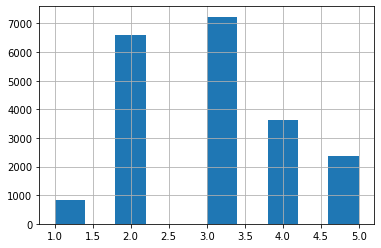

In [ ]:
#normalizing median income category
housing["income_cat"] = pd.cut(housing["median_income"],
                               bins=[0., 1.5, 3.0, 4.5, 6., np.inf],
                               labels=[1, 2, 3, 4, 5])

housing["income_cat"].hist()

#constructing useful features by combining data
housing["rooms_per_household"] = housing["total_rooms"]/housing["households"]
housing["bedrooms_per_room"] = housing["total_bedrooms"]/housing["total_rooms"]
housing["population_per_household"]=housing["population"]/housing["households"]

In [ ]:
from sklearn.model_selection import StratifiedShuffleSplit

#creating test and training set
split = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=42)
for train_index, test_index in split.split(housing, housing["income_cat"]):
    strat_train_set = housing.loc[train_index]
    strat_test_set = housing.loc[test_index]

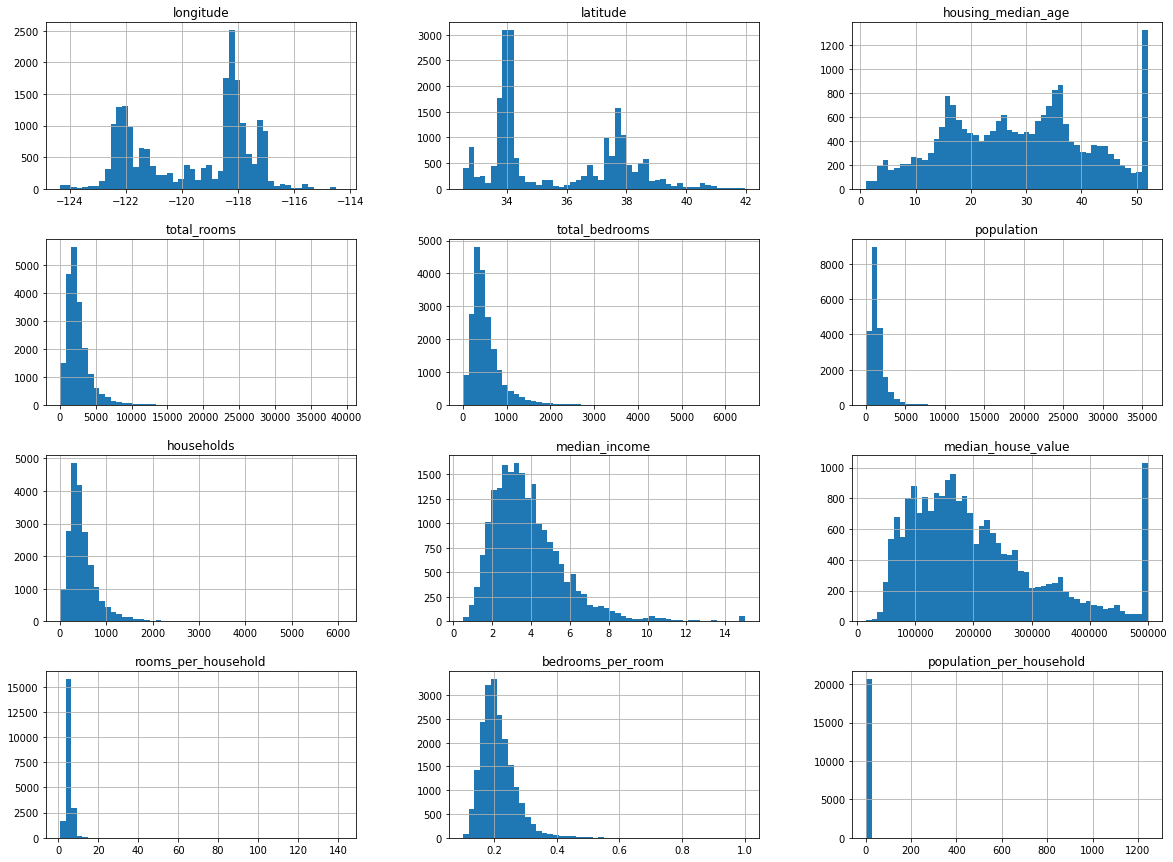

In [ ]:
%matplotlib inline
import matplotlib.pyplot as plt
housing.hist(bins=50, figsize=(20,15))
plt.show()

Most of the data is normally distributed with respect to each other, except for three which are bi-modal. This is good and means that it will generalize well in our unsupervised model.

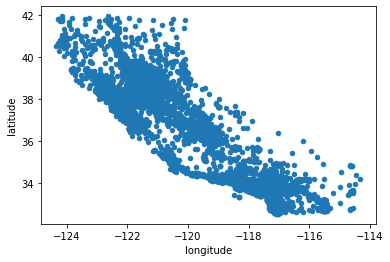

In [ ]:
housing.plot(kind="scatter", x="longitude", y="latitude")

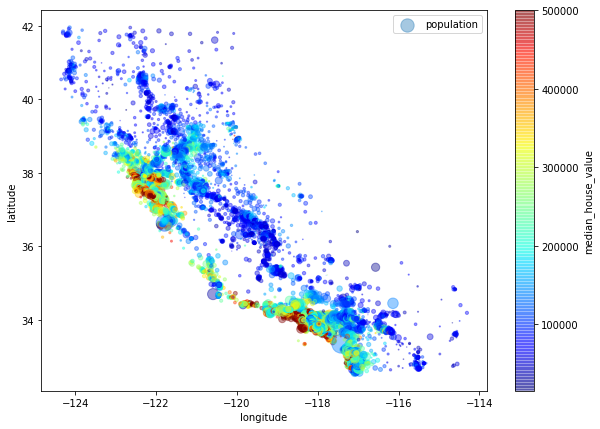

In [ ]:
housing.plot(kind="scatter", x="longitude", y="latitude", alpha=0.4,
    s=housing["population"]/100, label="population", figsize=(10,7),
    c="median_house_value", cmap=plt.get_cmap("jet"), colorbar=True,
    sharex=False)
plt.legend()

The first map shows all the data points that were collected and plots them based on latitude and longitude, this closely resembles the state of California. The second map plots the points based on latitude and longitude as well, but takes into account the priefc of the house. You can see that there are two large areas where the houses are very expensive, these correlate to San Francisco and Los Angeles. 

In [ ]:
corr_matrix = housing.corr()
corr_matrix["median_house_value"].sort_values(ascending=False)

median_house_value          1.000000
median_income               0.688075
rooms_per_household         0.151948
total_rooms                 0.134153
housing_median_age          0.105623
households                  0.065843
total_bedrooms              0.049686
population_per_household   -0.023737
population                 -0.024650
longitude                  -0.045967
latitude                   -0.144160
bedrooms_per_room          -0.255880
Name: median_house_value, dtype: float64

The correlation matrix of the data shows that median income has a strong positive correlation with the median house value. It also shows that total rooms and age have a weak positive correlation and that the bedrooms per household are negatively correlated with median house value . 

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7fc9ce4952e8>,
      dtype=object)

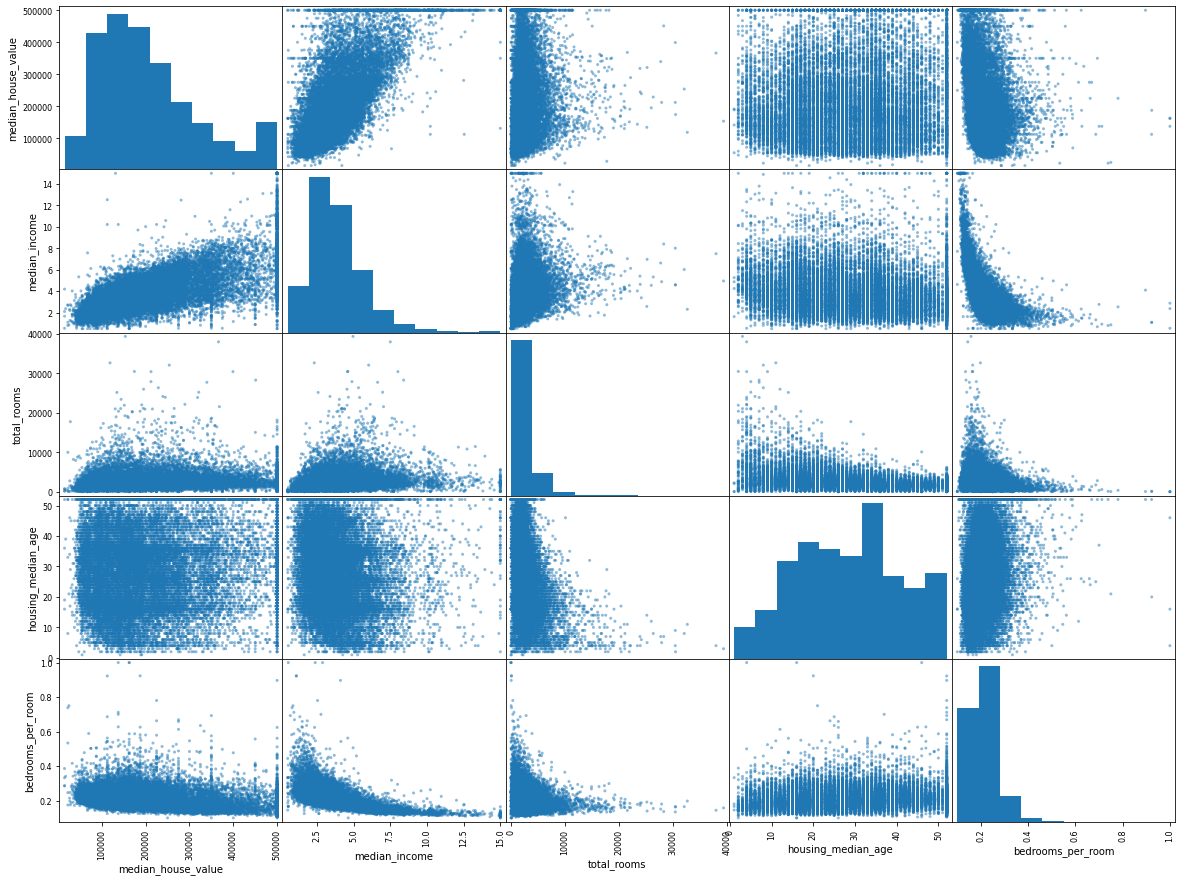

In [ ]:
from pandas.plotting import scatter_matrix

attributes = ["median_house_value", "median_income", "total_rooms",
              "housing_median_age", "bedrooms_per_room"]
scatter_matrix(housing[attributes], figsize=(20, 15))

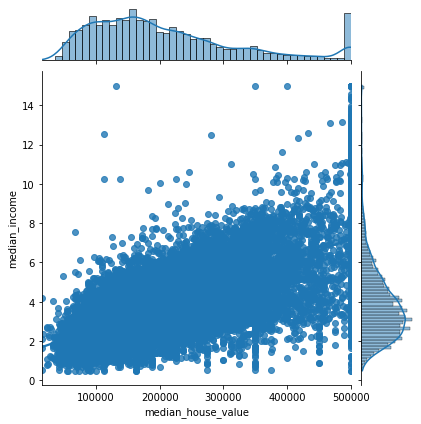

In [ ]:
import seaborn as sns

sns.jointplot(x=housing['median_house_value'], y=housing['median_income'], data=housing, kind='reg')

The two graphs above visually highlight the findings in the correlation matrix. You can see linear relationships between most of the elements. The second graph takes a closer look at the strongest relationship, median income and median house value.

In [ ]:
housing.describe()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,rooms_per_household,bedrooms_per_room,population_per_household
count,20640.000000,20640.000000,20640.000000,20640.000000,20433.000000,20640.000000,20640.000000,20640.000000,20640.000000,20640.000000,20433.000000,20640.000000
mean,-119.569704,35.631861,28.639486,2635.763081,537.870553,1425.476744,499.539680,3.870671,206855.816909,5.429000,0.213039,3.070655
std,2.003532,2.135952,12.585558,2181.615252,421.385070,1132.462122,382.329753,1.899822,115395.615874,2.474173,0.057983,10.386050
min,-124.350000,32.540000,1.000000,2.000000,1.000000,3.000000,1.000000,0.499900,14999.000000,0.846154,0.100000,0.692308
25%,-121.800000,33.930000,18.000000,1447.750000,296.000000,787.000000,280.000000,2.563400,119600.000000,4.440716,0.175427,2.429741
50%,-118.490000,34.260000,29.000000,2127.000000,435.000000,1166.000000,409.000000,3.534800,179700.000000,5.229129,0.203162,2.818116
75%,-118.010000,37.710000,37.000000,3148.000000,647.000000,1725.000000,605.000000,4.743250,264725.000000,6.052381,0.239821,3.282261
max,-114.310000,41.950000,52.000000,39320.000000,6445.000000,35682.000000,6082.000000,15.000100,500001.000000,141.909091,1.000000,1243.333333


In [ ]:
housing = strat_train_set.drop("median_house_value", axis=1) # drop labels for training set
housing_labels = strat_train_set["median_house_value"].copy()

housing_test = strat_test_set.drop("median_house_value", axis=1) # drop labels for test set
housing_test_labels = strat_test_set["median_house_value"].copy()

In [ ]:
sample_incomplete_rows = housing[housing.isnull().any(axis=1)].head()
sample_incomplete_rows

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,ocean_proximity,income_cat,rooms_per_household,bedrooms_per_room,population_per_household
4629,-118.30,34.07,18.0,3759.0,NaN,3296.0,1462.0,2.2708,<1H OCEAN,2,2.571135,NaN,2.254446
6068,-117.86,34.01,16.0,4632.0,NaN,3038.0,727.0,5.1762,<1H OCEAN,4,6.371389,NaN,4.178817
17923,-121.97,37.35,30.0,1955.0,NaN,999.0,386.0,4.6328,<1H OCEAN,4,5.064767,NaN,2.588083
13656,-117.30,34.05,6.0,2155.0,NaN,1039.0,391.0,1.6675,INLAND,2,5.511509,NaN,2.657289
19252,-122.79,38.48,7.0,6837.0,NaN,3468.0,1405.0,3.1662,<1H OCEAN,3,4.866192,NaN,2.468327


There are some rows that don't have complete data, that means we will have to use an Imputer to take care of these data points.

In [ ]:
from sklearn.base import BaseEstimator, TransformerMixin

rooms_ix, bedrooms_ix, population_ix, households_ix = 3, 4, 5, 6

class CombinedAttributesAdder(BaseEstimator, TransformerMixin):
    def __init__(self, add_bedrooms_per_room = True): # no *args or **kargs
        self.add_bedrooms_per_room = add_bedrooms_per_room
    def fit(self, X, y=None):
        return self  # nothing else to do
    def transform(self, X, y=None):
        rooms_per_household = X[:, rooms_ix] / X[:, households_ix]
        population_per_household = X[:, population_ix] / X[:, households_ix]
        if self.add_bedrooms_per_room:
            bedrooms_per_room = X[:, bedrooms_ix] / X[:, rooms_ix]
            return np.c_[X, rooms_per_household, population_per_household,
                         bedrooms_per_room]
        else:
            return np.c_[X, rooms_per_household, population_per_household]

In [ ]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
num_pipeline = Pipeline([
        ('imputer', SimpleImputer(strategy="median")),
        ('attribs_adder', CombinedAttributesAdder()),
        ('std_scaler', StandardScaler()),
    ])

housing_num = housing.drop("ocean_proximity", axis=1)

housing_num_tr = num_pipeline.fit_transform(housing_num)

In [ ]:
from sklearn.compose import ColumnTransformer

num_attribs = list(housing_num)
cat_attribs = ["ocean_proximity"]

full_pipeline = ColumnTransformer([
        ("num", num_pipeline, num_attribs),
        ("cat", OneHotEncoder(), cat_attribs),
    ])

housing_train_prepared = full_pipeline.fit_transform(housing)

In [ ]:
housing_num_test = housing_test.drop("ocean_proximity", axis=1)
num_attribs = list(housing_num_test)
cat_attribs = ["ocean_proximity"]

housing_test_prepared = full_pipeline.fit_transform(housing_test)

In [ ]:
# housing_prepared
print("Training set shape before and after the pipeline transformations:")
print(housing.shape)
print(housing_train_prepared.shape, "\n")
print("Testing set shape before and after the pipeline transformations:")
print(housing_test.shape)
print(housing_test_prepared.shape, "\n")
housing_train_prepared

Training set shape before and after the pipeline transformations:
(16512, 13)
(16512, 20) 

Testing set shape before and after the pipeline transformations:
(4128, 13)
(4128, 20) 



array([[-1.15604281,  0.77194962,  0.74333089, ...,  0.        ,
         0.        ,  0.        ],
       [-1.17602483,  0.6596948 , -1.1653172 , ...,  0.        ,
         0.        ,  0.        ],
       [ 1.18684903, -1.34218285,  0.18664186, ...,  0.        ,
         0.        ,  1.        ],
       ...,
       [ 1.58648943, -0.72478134, -1.56295222, ...,  0.        ,
         0.        ,  0.        ],
       [ 0.78221312, -0.85106801,  0.18664186, ...,  0.        ,
         0.        ,  0.        ],
       [-1.43579109,  0.99645926,  1.85670895, ...,  0.        ,
         1.        ,  0.        ]])

Now we have taken a look at our data and understand the correlation and how it relates to the problem we are trying to solve. We have also run our data through the pipeline in order to fill in any missing values, create combined attributes, encoded categorical data, and scaled all of our data. We are ready to go on to the next step and try and cluster the data.

- - -
## 2. IMPLEMENTING K-MEANS (40 pts)

You must implement your own version of K-Means Algorithm. Input a cluster count K and M data points each with its own vector of N features, along with the choice of a distance measure; then:

1. Initialize K centroids. In our case, a centroid is just the average of all data in a cluster.
2. Assign each data point to the cluster that has the closest centroid base on a **distance measure** below.
3. After all data points have been assigned to clusters, recalculate the centroids for each cluster (as averages of all points in the cluster).
4. Repeat the data assignments and centroid calculations until no change in housing assignment occurs between iterations.

**Distance Measures:** Your implementation must include three distance metrics: Manhattan Distance, Euclidean Distance, Sup Distance. These 3 distance metrics can be generalized by the Minkovski Distance:
$D(\mathbf{x},\mathbf{y}) = \sqrt[\leftroot{2}\uproot{2}p]{\sum\limits_{i=1}^n|x_i - y_i|^p}$ where $p=1$ for Mahattan, $p=2$ for Euclidean, and $p=\infty$ for Sup Distance.

**Implementation Notes:** Note that your functions should return distance measures; that is, the returned value should be high if the two vectors are dissimilar, low if they are similar, and zero if they are completely identical.

In [ ]:
# Function: K Means
# -------------
# K-Means is an algorithm that takes in a dataset and a constant
# k and returns k centroids (which define clusters of data in the
# dataset which are similar to one another).
import numpy as np


class K_means():

  def __init__(self, k=2, p=2):
    self.k = k
    self.p = p

  def distance(self, x, y):
    inside = 0
    if self.p == np.inf:
      max_dist = 0
      for a, b in zip(x,y):
        dist = abs(a-b)
        if dist > max_dist:
          max_dist = dist
      return max_dist

    for a, b in zip(x,y):
      inside += abs(a-b)**self.p

    return inside**(1/self.p)

  def fit(self, data, iters=100):
    #Randomly assign k centroids
    n_samples, n_features = np.shape(data)
    centroids = np.zeros((self.k, n_features))
    for i in range(self.k):
        centroids[i] = data[np.random.choice(range(n_samples))]

    #holds the current cluster of each point
    curr_cluster = np.zeros((n_samples))

    recalculate = True

    while recalculate:
      # print("Iterations inertia: ",self.inertia(data, curr_cluster, centroids))
      recalculate = False

      # for every point, calculate its cluster
      for i in range(len(data)):
        cluster = 0
        min_dist = np.inf
        for centroid in range(self.k):
          dist = self.distance(data[i], centroids[centroid])
          if centroid == 0:
            min_dist = dist
          elif dist < min_dist:
            min_dist = dist
            cluster = centroid

        #see if any centroids changed
        if cluster != curr_cluster[i]:
          recalculate = True
          curr_cluster[i] = cluster

      # recalucalte centroids based on new mean
      for centroid in centroids:
        centroid = np.mean(centroid)

    return curr_cluster, centroids

  def predict(self, y, centroids):
    y_pred = np.zeros(np.shape(y)[0])

    for i, y in enumerate(y):
      min_dist = np.inf
      centroid = -1

      for j, c in enumerate(centroids):
        dist = self.distance(y, c)

        if dist < min_dist:
          centroid = j
          min_dist = dist

      y_pred[i] = centroid

    return y_pred

  def inertia(self, data, clusters, centroids):
    #Use this to determine the best number of clusters to use
    sum_error = 0
    for i in range(len(data)):
      sum_error += (centroids[int(clusters[i])] - data[i])**2
    return np.sum(sum_error)

  def std_dev(self, data, cluster, centroids):
    # statistic to show how each cluster varies
    avg = []
    count = np.zeros(len(centroids))
    for i in range(len(centroids)):
      avg.append(np.zeros(data.shape[1]))

    for i in range(data.shape[0]):
      clus = int(cluster[i])
      avg[clus] += ((data[i] - centroids[clus])**2)
      count[clus] += 1

    for i in range(len(count)):
      avg[i] /= count[i]
      avg[i] **= 0.5
    return avg

- - -
## 3. CLUSTERING HOUSING INTO REGIONS (40 pts)

Now that you have implemented the K-Means as the clustering algorithm. Applying the algorithm for k=2 clusters to see if you can split California into a Northern and Southern regions.

* **Cluster the data:** Report the SSE (sum squared error), cluster means, within cluster standard deviations for each attribute, etc. Visualize the clustering by plot the latitude along the X axis and longitude along the Y axis. You should get a plot that looks roughly in the shape of California (see Chapter 2 for more details). Using the cluster means and std. deviations as representative values in the cluster, what can you say about the clusters that were found? How do they compare with what you know about cities and areas in California? What can you attribute the gaps to? It will definitely be helpful to have a map of California handy.

* **Change the number of clusters:** Increase the value of k from 2 to 3,4,..,10 and repeat the clustering process above. Record cluster means and standard deviations. When you change k, do any additional patterns emerge? If so, what are they? Applying the algorithm for 10 clusters to see if it clearly identified the silicon valley area as one cluster (where houses are relatively new and expensive, median income is high), the area of San Francisco as another etc. While SF and Silicon Valley may have a somewhat similar profile (at least, compared with mid CA), they were separated mainly due to the latitude/longtitue properties, that involve a dimension of geographical cohesiveness.


Iteration where k=2 and p=1

Iteration SSE:  294271.6085661112

Standard deviations in clusters: 
 [array([1.00877078, 0.7389554 , 1.20969072, 0.76550792, 1.02291116,
       0.89145029, 1.01429511, 0.79536945, 0.85310117, 0.53722619,
       1.06661072, 1.2911764 , 0.53722619, 1.2911764 , 1.13307559,
       0.75745917, 0.89651228, 0.01701404, 0.27931019, 0.38946913]), array([1.08996683, 0.99556219, 0.94921866, 1.22836369, 1.13213416,
       1.11348974, 1.13099257, 1.4873246 , 1.66200411, 1.17032652,
       0.69506174, 0.72211763, 1.17032652, 0.72211763, 0.68708037,
       0.58727525, 0.77016101, 0.        , 0.36906291, 0.33473619])]

Cluster means (centroids): 
 [[ 1.13189847 -0.72945862  1.14096591 -0.43290828 -0.35781012 -0.21403692
  -0.38609722 -1.02482947 -0.95445595 -0.23713817  0.26730262  0.02232956
  -0.23713817  0.02232956  0.21955478  0.          1.          0.
   0.          0.        ]
 [ 0.11781096  0.45857157 -0.21099316 -0.32768911 -0.47464757 -0.24361603
  -0.43932984 -

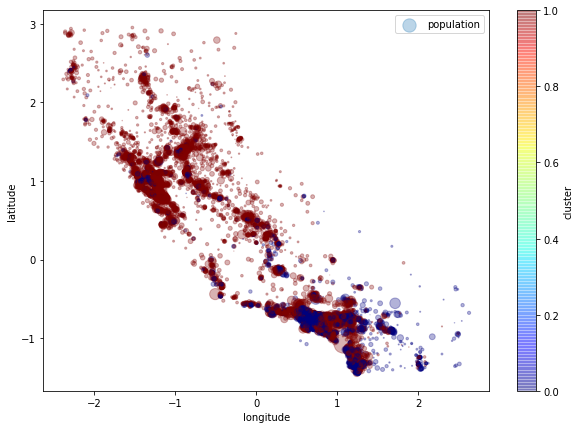

In [ ]:
# Iteration where k=2 and p=1
iter1 = K_means(k=2, p=1)
cluster, centroid = iter1.fit(housing_train_prepared)

iter1_sse = iter1.inertia(housing_train_prepared, cluster, centroid)

print("Iteration where k=2 and p=1")
print("\nIteration SSE: ", iter1_sse)
print("\nStandard deviations in clusters: \n", iter1.std_dev(housing_train_prepared, cluster, centroid))
print("\nCluster means (centroids): \n", centroid)

housing_kmean = np.c_[housing_train_prepared, cluster]

housing_kmean_dataframe = pd.DataFrame(housing_kmean, columns=['longitude', 'latitude', 'housing_median_age', 'total_rooms',
                                                              'total_bedrooms', 'population', 'households', 'median_income',
                                                              'median_house_value', 'ocean_proximity', 'rooms_per_household',
                                                              'bedrooms_per_room', 'population_per_household', 'a', 'b', 'c', 'd', 'e', 'f', 'g', 'cluster'])

housing_kmean_dataframe.plot(kind="scatter", x="longitude", y="latitude", alpha=0.3,
    s=housing["population"]/100, label="population", figsize=(10,7),
    c="cluster", cmap=plt.get_cmap("jet"), colorbar=True,
    sharex=False)
plt.legend()


K-means cluster where k=2 and p=1 gave a very North/South split. This makes sense since we only have 2 groups for data points to go into, it's naturally broken up by latitude and longitude. 

Iteration where k=2 and p=2

Iteration SSE:  372410.44125911815

Standard deviations in clusters: 
 [array([1.46417785, 1.59060349, 1.25327209, 1.0246861 , 1.19120257,
       1.16805312, 1.23550835, 0.57211493, 0.81677127, 1.47373285,
       1.19188153, 1.56058099, 1.47373285, 1.56058099, 1.27390788,
       0.42872692, 0.68290023, 0.01232503, 0.43922791, 0.29912018]), array([0.8163945 , 0.69998086, 1.65300922, 1.29663816, 1.34998062,
       1.46676159, 1.33408396, 1.34452962, 1.80020642, 0.66589498,
       1.11964414, 0.24115821, 0.66589498, 0.24115821, 1.00078187,
       0.62374862, 0.41982304, 0.01003569, 0.24106555, 0.39318907])]

Cluster means (centroids): 
 [[-1.9503281   2.1985213  -0.76768218 -0.98425671 -1.0369278  -1.07900163
  -1.11006087 -0.61278509 -0.95445595  0.39617342 -0.07510967 -0.03422144
   0.39617342 -0.03422144 -0.07971635  0.          1.          0.
   0.          0.        ]
 [ 0.58239293 -0.69671763  1.37954692 -0.46517549 -0.66937665 -0.82444207
  -0.63629054 

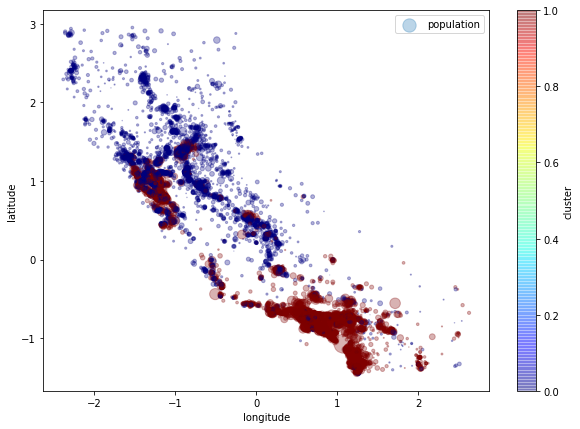

In [ ]:
# Iteration where k=2 and p=2
iter2 = K_means(k=2)
cluster, centroid = iter2.fit(housing_train_prepared)

iter2_sse = iter2.inertia(housing_train_prepared, cluster, centroid)

print("Iteration where k=2 and p=2")
print("\nIteration SSE: ", iter2_sse)
print("\nStandard deviations in clusters: \n", iter2.std_dev(housing_train_prepared, cluster, centroid))
print("\nCluster means (centroids): \n", centroid)

housing_kmean = np.c_[housing_train_prepared, cluster]

housing_kmean_dataframe = pd.DataFrame(housing_kmean, columns=['longitude', 'latitude', 'housing_median_age', 'total_rooms',
                                                              'total_bedrooms', 'population', 'households', 'median_income',
                                                              'median_house_value', 'ocean_proximity', 'rooms_per_household',
                                                              'bedrooms_per_room', 'population_per_household', 'a', 'b', 'c', 'd', 'e', 'f', 'g', 'cluster'])

housing_kmean_dataframe.plot(kind="scatter", x="longitude", y="latitude", alpha=0.3,
    s=housing["population"]/100, label="population", figsize=(10,7),
    c="cluster", cmap=plt.get_cmap("jet"), colorbar=True,
    sharex=False)
plt.legend()

K-means cluster where k=2 and p=2 gave an even more pronounced North/South split than with p=1. 

Iteration where k=2 and p=infinity

Iteration SSE:  302353.08538482426

Standard deviations in clusters: 
 [array([0.85569674, 0.90985107, 1.10445909, 0.67455846, 0.75648852,
       0.64671186, 0.77488224, 0.79613678, 1.03949331, 0.45141064,
       1.14365881, 1.42489424, 0.45141064, 1.42489424, 1.19389425,
       0.76897844, 0.4665444 , 0.01567387, 0.18677567, 0.91876131]), array([0.90755303, 1.17750827, 1.16429348, 1.59244087, 1.38519724,
       1.43939264, 1.46842033, 1.21587179, 1.1350576 , 1.30310476,
       0.92785578, 0.07153261, 1.30310476, 0.07153261, 0.81523058,
       0.54231967, 0.76352145, 0.        , 0.43210652, 0.31959089])]

Cluster means (centroids): 
 [[ 1.2567861  -1.42169668 -0.37004716 -0.71770149 -0.64746963 -0.29112186
  -0.66823011 -0.76460473 -0.95445595 -0.38963224  0.5872801   0.11694808
  -0.38963224  0.11694808  0.4992177   0.          0.          0.
   0.          1.        ]
 [-0.82633948  1.42676941 -0.76768218  1.23703681  0.76675033  0.84005478
   0.93

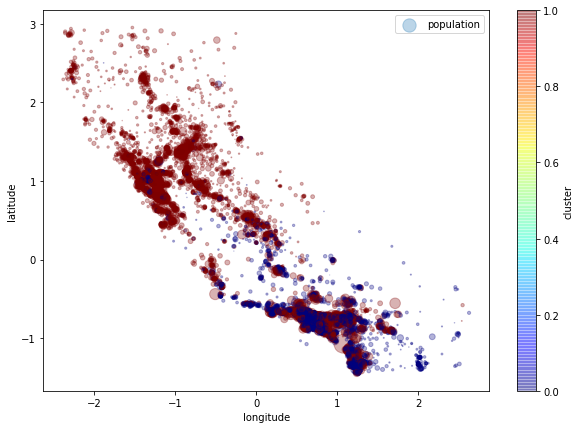

In [ ]:
# Iteration where k=2 and p=np.inf
iter3 = K_means(k=2, p=np.inf)
cluster, centroid = iter3.fit(housing_train_prepared)

iter3_sse = iter3.inertia(housing_train_prepared, cluster, centroid)

print("Iteration where k=2 and p=infinity")
print("\nIteration SSE: ", iter3_sse)
print("\nStandard deviations in clusters: \n", iter3.std_dev(housing_train_prepared, cluster, centroid))
print("\nCluster means (centroids): \n", centroid)

housing_kmean = np.c_[housing_train_prepared, cluster]

housing_kmean_dataframe = pd.DataFrame(housing_kmean, columns=['longitude', 'latitude', 'housing_median_age', 'total_rooms',
                                                              'total_bedrooms', 'population', 'households', 'median_income',
                                                              'median_house_value', 'ocean_proximity', 'rooms_per_household',
                                                              'bedrooms_per_room', 'population_per_household', 'a', 'b', 'c', 'd', 'e', 'f', 'g', 'cluster'])

housing_kmean_dataframe.plot(kind="scatter", x="longitude", y="latitude", alpha=0.3,
    s=housing["population"]/100, label="population", figsize=(10,7),
    c="cluster", cmap=plt.get_cmap("jet"), colorbar=True,
    sharex=False)
plt.legend()

K-means cluster where k=2 and p=infinity produced the weakest North/South split. It still split it by latitude, but there are red points near San Francisco and Los Angeles which means that it is accounting for more median income and population.

Iteration where k=3 and p=2

Iteration SSE:  271106.9026413511

Standard deviations in clusters: 
 [array([1.01890414, 0.94502802, 1.34348064, 0.9196232 , 0.76530978,
       0.76058792, 0.80173495, 1.48227606, 1.17289717, 1.41133055,
       0.65561203, 1.56032127, 1.41133055, 1.56032127, 0.59447845,
       0.78895916, 0.51876992, 0.        , 0.48472892, 0.34405261]), array([0.95770901, 0.98253001, 0.76380143, 1.02028661, 1.01714574,
       1.02968986, 0.9984388 , 0.92674589, 0.85519633, 0.65818038,
       0.95732805, 0.15932837, 0.65818038, 0.15932837, 0.9428208 ,
       0.31498277, 0.47152027, 0.        , 0.23102516, 0.26409202]), array([0.51151317, 0.43270435, 1.1162387 , 1.31215504, 1.32904698,
       1.49165696, 1.30412309, 0.76276216, 0.97213522, 0.45764088,
       1.08673594, 0.13930701, 0.45764088, 0.13930701, 1.1541717 ,
       0.58405072, 0.4       , 0.01724522, 0.12315554, 0.40700191])]

Cluster means (centroids): 
 [[-1.12606978e+00  8.09367890e-01  1.14096591e+00 -5.4327149

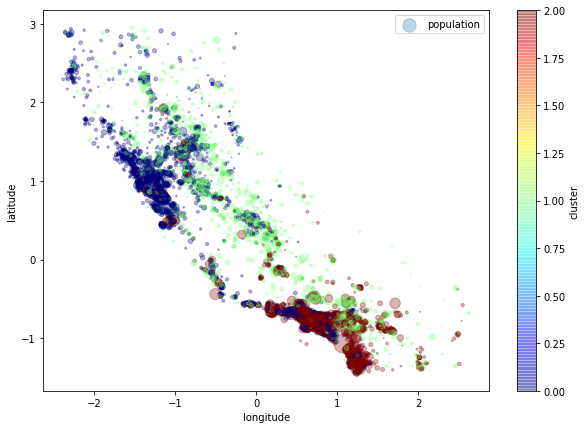

In [ ]:
# Iteration where k=3 and p=2
iter4 = K_means(k=3, p=2)
cluster, centroid = iter4.fit(housing_train_prepared)

iter4_sse = iter4.inertia(housing_train_prepared, cluster, centroid)

print("Iteration where k=3 and p=2")
print("\nIteration SSE: ", iter4_sse)
print("\nStandard deviations in clusters: \n", iter4.std_dev(housing_train_prepared, cluster, centroid))
print("\nCluster means (centroids): \n", centroid)

housing_kmean = np.c_[housing_train_prepared, cluster]

housing_kmean_dataframe = pd.DataFrame(housing_kmean, columns=['longitude', 'latitude', 'housing_median_age', 'total_rooms',
                                                              'total_bedrooms', 'population', 'households', 'median_income',
                                                              'median_house_value', 'ocean_proximity', 'rooms_per_household',
                                                              'bedrooms_per_room', 'population_per_household', 'a', 'b', 'c', 'd', 'e', 'f', 'g', 'cluster'])

housing_kmean_dataframe.plot(kind="scatter", x="longitude", y="latitude", alpha=0.3,
    s=housing["population"]/100, label="population", figsize=(10,7),
    c="cluster", cmap=plt.get_cmap("jet"), colorbar=True,
    sharex=False)
plt.legend()

K-means cluster where k=3 and p=2 did not split by North/South. The data seems to be all over the place until you see that the blue group is tightly centerde around San Francisco and the red are tightly centered around L.A. The third group (green) runs down the middle of California, encompassing Sacramento and Fresno.

Iteration where k=4 and p=2

Iteration SSE:  256975.9338877547

Standard deviations in clusters: 
 [array([0.76334102, 0.66459407, 0.88283797, 0.57274777, 0.85182899,
       0.81720144, 0.87073037, 0.94471816, 1.37819062, 0.45639173,
       1.62362108, 0.52976858, 0.45639173, 0.52976858, 2.04378094,
       0.40404317, 0.19353509, 0.        , 0.58060526, 0.36931797]), array([1.32590636, 1.09907016, 0.88576482, 1.49124774, 1.44998483,
       1.5850632 , 1.44562545, 1.08116512, 0.90627869, 0.71530152,
       0.80197012, 0.08152963, 0.71530152, 0.08152963, 0.71416329,
       0.68246323, 0.48227529, 0.        , 0.33576133, 0.34703161]), array([0.32020875, 0.25419445, 1.21662291, 0.75049368, 0.7563434 ,
       0.80276885, 0.77402288, 1.02634078, 0.94443043, 0.61863785,
       1.14821415, 0.14251291, 0.61863785, 0.14251291, 1.06288493,
       0.51021751, 0.31411845, 0.01870548, 0.01870548, 0.40118788]), array([0.9632217 , 1.13050079, 0.91188306, 0.48839896, 0.64044126,
       0.64813028, 0.59

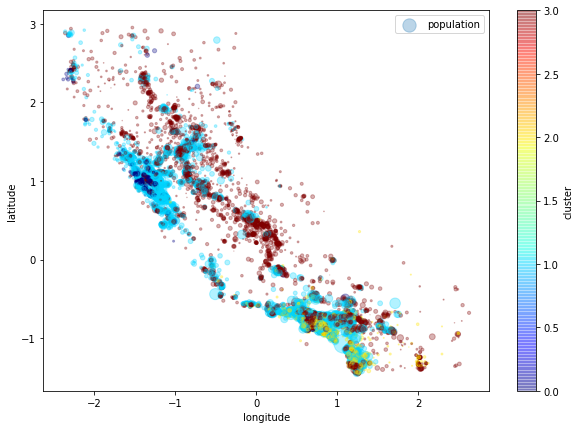

In [ ]:
# Iteration where k=4 and p=2
iter5 = K_means(k=4, p=2)
cluster, centroid = iter5.fit(housing_train_prepared)

iter5_sse = iter5.inertia(housing_train_prepared, cluster, centroid)

print("Iteration where k=4 and p=2")
print("\nIteration SSE: ", iter5_sse)
print("\nStandard deviations in clusters: \n", iter5.std_dev(housing_train_prepared, cluster, centroid))
print("\nCluster means (centroids): \n", centroid)

housing_kmean = np.c_[housing_train_prepared, cluster]

housing_kmean_dataframe = pd.DataFrame(housing_kmean, columns=['longitude', 'latitude', 'housing_median_age', 'total_rooms',
                                                              'total_bedrooms', 'population', 'households', 'median_income',
                                                              'median_house_value', 'ocean_proximity', 'rooms_per_household',
                                                              'bedrooms_per_room', 'population_per_household', 'a', 'b', 'c', 'd', 'e', 'f', 'g', 'cluster'])

housing_kmean_dataframe.plot(kind="scatter", x="longitude", y="latitude", alpha=0.3,
    s=housing["population"]/100, label="population", figsize=(10,7),
    c="cluster", cmap=plt.get_cmap("jet"), colorbar=True,
    sharex=False)
plt.legend()

K-means clustering with k=4 and p=2 produced an interesting graph. It's similar to k=3, but it has more accurately pinpointed both San Francisco and L.A. It still has the group that runs down the middle, but now it has a group that surrounds both of the large cities.

Iteration where k=5 and p=2

Iteration SSE:  233488.0729262336

Standard deviations in clusters: 
 [array([1.04230785, 0.82200207, 0.70616234, 1.13773538, 0.91167203,
       1.00742873, 0.83863776, 1.05630058, 0.86073702, 0.89839556,
       0.43345984, 0.06533227, 0.89839556, 0.06533227, 0.39472815,
       0.58760054, 0.71514539, 0.        , 0.17460757, 0.36833508]), array([0.63651649, 0.54491056, 0.85429493, 0.40267923, 0.35556125,
       0.37385593, 0.36324764, 1.10251369, 0.96753911, 1.63052693,
       0.77451063, 0.74297873, 1.63052693, 0.74297873, 0.70352157,
       0.5720621 , 0.38447883, 0.01559268, 0.21093381, 0.367008  ]), array([0.56139844, 0.57277141, 1.34628457, 0.52560871, 0.4805756 ,
       0.46218551, 0.48096327, 1.16169878, 1.26247759, 0.8016839 ,
       0.73827547, 0.06244073, 0.8016839 , 0.06244073, 0.70809363,
       0.31467381, 0.6460033 , 0.        , 0.46582557, 0.3182879 ]), array([0.88735168, 0.86709697, 1.10790662, 1.59512291, 1.55418452,
       1.63857051, 1.51

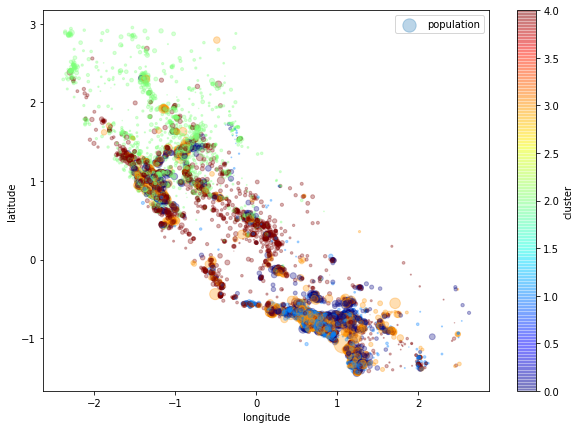

In [ ]:
# Iteration where k=5 and p=2
iter6 = K_means(k=5, p=2)
cluster, centroid = iter6.fit(housing_train_prepared)

iter6_sse = iter6.inertia(housing_train_prepared, cluster, centroid)

print("Iteration where k=5 and p=2")
print("\nIteration SSE: ", iter6_sse)
print("\nStandard deviations in clusters: \n", iter6.std_dev(housing_train_prepared, cluster, centroid))
print("\nCluster means (centroids): \n", centroid)

housing_kmean = np.c_[housing_train_prepared, cluster]

housing_kmean_dataframe = pd.DataFrame(housing_kmean, columns=['longitude', 'latitude', 'housing_median_age', 'total_rooms',
                                                              'total_bedrooms', 'population', 'households', 'median_income',
                                                              'median_house_value', 'ocean_proximity', 'rooms_per_household',
                                                              'bedrooms_per_room', 'population_per_household', 'a', 'b', 'c', 'd', 'e', 'f', 'g', 'cluster'])

housing_kmean_dataframe.plot(kind="scatter", x="longitude", y="latitude", alpha=0.3,
    s=housing["population"]/100, label="population", figsize=(10,7),
    c="cluster", cmap=plt.get_cmap("jet"), colorbar=True,
    sharex=False)
plt.legend()

K-means clustering with k=5 and p=2 was able to cluster the data the best so far. It has seperated the heart of L.A.(light blue) into it's own group as well as San Francisco(red). On top of that, it has clustered lower income areas together(green). It was also able to create a middle of the road group as well, this is in darker blue and is centered in Sacramento and around L.A. I believe the orange is in it's own group based on population, there is orange near Death Valley which isn't heavily populated.

Iteration where k=6 and p=2

Iteration SSE:  214407.4102455099

Standard deviations in clusters: 
 [array([0.6963867 , 0.70903031, 1.14539436, 1.60068406, 1.49395526,
       1.56097429, 1.49885717, 0.78999563, 0.87044778, 0.44493393,
       0.63990281, 0.0582727 , 0.44493393, 0.0582727 , 0.57406786,
       0.49079559, 0.56689923, 0.        , 0.82798505, 0.35114696]), array([0.74349764, 0.63186181, 0.96275742, 0.83525682, 0.92336392,
       0.87872633, 0.87977511, 0.53022494, 0.78147779, 0.76953279,
       0.55558717, 0.07682831, 0.76953279, 0.07682831, 0.50816142,
       0.52167112, 0.65298772, 0.01712469, 0.        , 0.39237602]), array([0.48135498, 0.41586084, 1.1813522 , 0.49589668, 0.71640499,
       0.72574059, 0.70532377, 0.59905003, 0.81430404, 0.29050654,
       1.0091353 , 0.16355895, 0.29050654, 0.16355895, 0.90835195,
       0.43818981, 0.20699744, 0.01794895, 0.05952995, 0.38117764]), array([0.45368166, 0.30522816, 1.29678716, 0.76338246, 0.54722026,
       0.49786927, 0.57

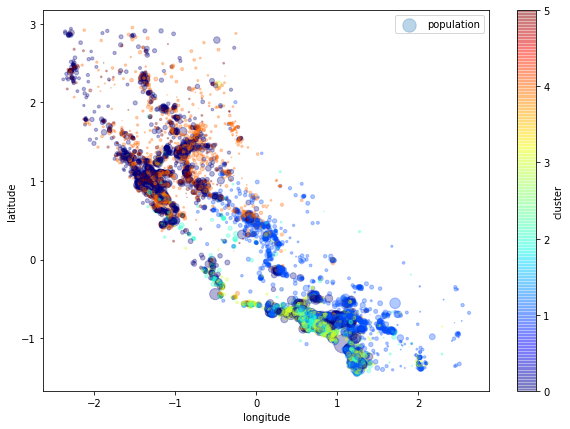

In [ ]:
# Iteration where k=6 and p=2
iter7 = K_means(k=6, p=2)
cluster, centroid = iter7.fit(housing_train_prepared)

iter7_sse = iter7.inertia(housing_train_prepared, cluster, centroid)

print("Iteration where k=6 and p=2")
print("\nIteration SSE: ", iter7_sse)
print("\nStandard deviations in clusters: \n", iter7.std_dev(housing_train_prepared, cluster, centroid))
print("\nCluster means (centroids): \n", centroid)

housing_kmean = np.c_[housing_train_prepared, cluster]

housing_kmean_dataframe = pd.DataFrame(housing_kmean, columns=['longitude', 'latitude', 'housing_median_age', 'total_rooms',
                                                              'total_bedrooms', 'population', 'households', 'median_income',
                                                              'median_house_value', 'ocean_proximity', 'rooms_per_household',
                                                              'bedrooms_per_room', 'population_per_household', 'a', 'b', 'c', 'd', 'e', 'f', 'g', 'cluster'])

housing_kmean_dataframe.plot(kind="scatter", x="longitude", y="latitude", alpha=0.3,
    s=housing["population"]/100, label="population", figsize=(10,7),
    c="cluster", cmap=plt.get_cmap("jet"), colorbar=True,
    sharex=False)
plt.legend()

K-means clustering with k=6 and p=2 looks very similar to k=5. I think the only difference is that it has split the lower income group into two based on North/South. This is shown by the orange and medium blue.

Iteration where k=7 and p=2

Iteration SSE:  199979.3016824184

Standard deviations in clusters: 
 [array([0.64054655, 0.81163923, 1.02982164, 0.45963634, 0.43260701,
       0.40667968, 0.44005919, 0.66219872, 0.77088536, 0.38841747,
       0.60210805, 0.99224513, 0.38841747, 0.99224513, 0.53370201,
       0.44031956, 0.78009706, 0.01919885, 0.54336463, 0.3450455 ]), array([1.12465446, 1.12234317, 0.69131438, 2.0590713 , 1.7127959 ,
       2.0545971 , 1.73873991, 0.83005781, 0.94825371, 0.56187153,
       1.1473086 , 0.06793179, 0.56187153, 0.06793179, 1.0122186 ,
       0.73029674, 0.60433219, 0.        , 0.26375219, 0.3139279 ]), array([0.81863021, 0.97628715, 0.96820657, 2.32219021, 2.47251703,
       0.30694425, 0.40836309, 0.79308151, 0.8481439 , 9.00296277,
       0.62101185, 0.03588589, 9.00296277, 0.03588589, 0.54276942,
       0.        , 0.14142136, 0.        , 0.        , 0.14142136]), array([0.61726986, 0.52499568, 0.89508778, 0.86091607, 0.78808538,
       0.69684206, 0.70

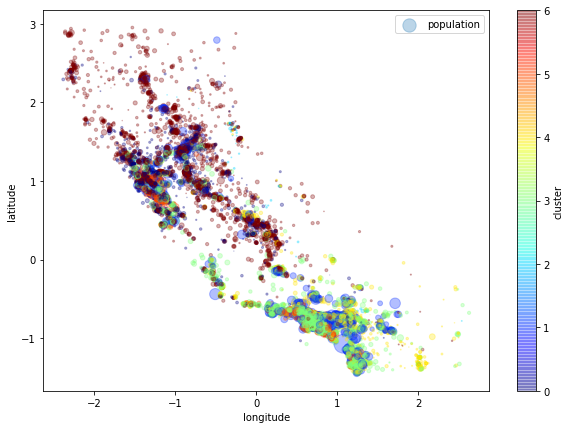

In [ ]:
# Iteration where k=7 and p=2
iter8 = K_means(k=7, p=2)
cluster, centroid = iter8.fit(housing_train_prepared)

iter8_sse = iter8.inertia(housing_train_prepared, cluster, centroid)

print("Iteration where k=7 and p=2")
print("\nIteration SSE: ", iter8_sse)
print("\nStandard deviations in clusters: \n", iter8.std_dev(housing_train_prepared, cluster, centroid))
print("\nCluster means (centroids): \n", centroid)

housing_kmean = np.c_[housing_train_prepared, cluster]

housing_kmean_dataframe = pd.DataFrame(housing_kmean, columns=['longitude', 'latitude', 'housing_median_age', 'total_rooms',
                                                              'total_bedrooms', 'population', 'households', 'median_income',
                                                              'median_house_value', 'ocean_proximity', 'rooms_per_household',
                                                              'bedrooms_per_room', 'population_per_household', 'a', 'b', 'c', 'd', 'e', 'f', 'g', 'cluster'])

housing_kmean_dataframe.plot(kind="scatter", x="longitude", y="latitude", alpha=0.3,
    s=housing["population"]/100, label="population", figsize=(10,7),
    c="cluster", cmap=plt.get_cmap("jet"), colorbar=True,
    sharex=False)
plt.legend()

K-means clustering with k=7 and p=2 has split the data by North/South. San Francisco and LA are singled out in orange. The midum income houses are shown in blue, Sacramento to Fresno and around the large cities. Red and yellow are the North/south split of lower income and population areas. 

Iteration where k=8 and p=2

Iteration SSE:  212019.64287734014

Standard deviations in clusters: 
 [array([1.05775676, 1.1455496 , 0.67053006, 0.34749662, 0.43225856,
       0.4288685 , 0.42669572, 0.35227494, 0.71936792, 0.56199503,
       0.74784025, 0.08394018, 0.56199503, 0.08394018, 0.65361847,
       0.12777531, 0.30639444, 0.        , 0.11065667, 0.25555063]), array([0.75127314, 0.6914867 , 0.94350833, 1.06874084, 1.38208335,
       1.22090818, 1.35334767, 0.44675269, 0.59349179, 0.42257756,
       1.86739848, 0.10376654, 0.42257756, 0.10376654, 2.42039594,
       0.57295363, 0.37139068, 0.        , 0.25188941, 0.35622542]), array([1.2719859 , 1.11373674, 0.87647704, 0.67342871, 0.70651199,
       0.58527171, 0.54650839, 1.35030261, 1.17655754, 2.76587243,
       0.53832224, 0.07609007, 2.76587243, 0.07609007, 0.47876975,
       0.46208305, 0.55003955, 0.        , 0.20371385, 0.21799869]), array([1.59930512, 1.25973872, 1.46686894, 1.70469991, 1.62566344,
       1.74108564, 1.5

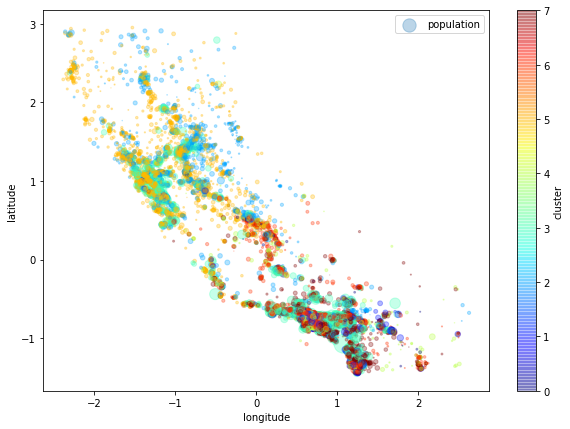

In [ ]:
# Iteration where k=8 and p=2
iter9 = K_means(k=8, p=2)
cluster, centroid = iter9.fit(housing_train_prepared)

iter9_sse = iter9.inertia(housing_train_prepared, cluster, centroid)

print("Iteration where k=8 and p=2")
print("\nIteration SSE: ", iter9_sse)
print("\nStandard deviations in clusters: \n", iter9.std_dev(housing_train_prepared, cluster, centroid))
print("\nCluster means (centroids): \n", centroid)

housing_kmean = np.c_[housing_train_prepared, cluster]

housing_kmean_dataframe = pd.DataFrame(housing_kmean, columns=['longitude', 'latitude', 'housing_median_age', 'total_rooms',
                                                              'total_bedrooms', 'population', 'households', 'median_income',
                                                              'median_house_value', 'ocean_proximity', 'rooms_per_household',
                                                              'bedrooms_per_room', 'population_per_household', 'a', 'b', 'c', 'd', 'e', 'f', 'g', 'cluster'])

housing_kmean_dataframe.plot(kind="scatter", x="longitude", y="latitude", alpha=0.3,
    s=housing["population"]/100, label="population", figsize=(10,7),
    c="cluster", cmap=plt.get_cmap("jet"), colorbar=True,
    sharex=False)
plt.legend()

K-means clustering with k=8 and p=2 has produced a graph very similar to k=7. The only real difference is that it has split the Sacramento to Fresno group into North and South(yellow and orange).

Iteration where k=9 and p=2

Iteration SSE:  168217.94182468764

Standard deviations in clusters: 
 [array([0.22696929, 0.29511027, 0.85910859, 0.77462215, 0.88373783,
       0.78426015, 0.87848598, 0.60702806, 0.73042471, 0.31230129,
       0.64122209, 0.05429992, 0.31230129, 0.05429992, 0.57708402,
       0.35895652, 0.27001874, 0.        , 0.59433741, 0.38920054]), array([0.92119716, 0.665141  , 0.67301897, 0.47351649, 0.48016272,
       0.41347974, 0.40229151, 0.61766365, 0.75738904, 2.05914662,
       0.57926794, 0.05997278, 2.05914662, 0.05997278, 0.51577692,
       0.3661521 , 0.50129366, 0.        , 0.24804939, 0.23600738]), array([1.08607226, 0.99915242, 0.68767758, 2.19133977, 1.81391902,
       2.32594894, 1.85020984, 1.18552986, 1.41729974, 0.65653871,
       1.01327404, 0.06041118, 0.65653871, 0.06041118, 0.89531206,
       0.72944575, 0.62884428, 0.        , 0.21821789, 0.29837378]), array([1.11875044, 0.89186894, 1.07521807, 0.86661867, 0.70393365,
       0.76167579, 0.7

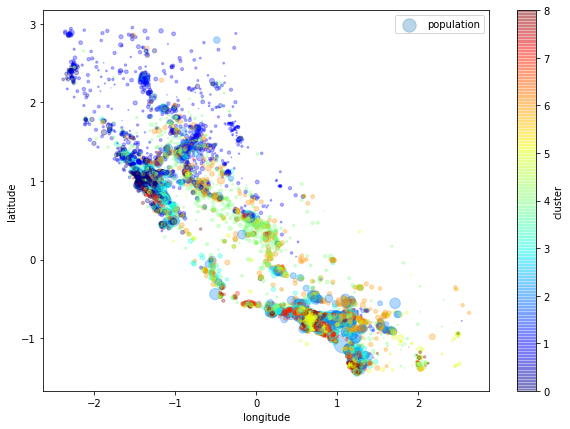

In [ ]:
# Iteration where k=9 and p=2
iter10 = K_means(k=9, p=2)
cluster, centroid = iter10.fit(housing_train_prepared)

iter10_sse = iter10.inertia(housing_train_prepared, cluster, centroid)

print("Iteration where k=9 and p=2")
print("\nIteration SSE: ", iter10_sse)
print("\nStandard deviations in clusters: \n", iter10.std_dev(housing_train_prepared, cluster, centroid))
print("\nCluster means (centroids): \n", centroid)

housing_kmean = np.c_[housing_train_prepared, cluster]

housing_kmean_dataframe = pd.DataFrame(housing_kmean, columns=['longitude', 'latitude', 'housing_median_age', 'total_rooms',
                                                              'total_bedrooms', 'population', 'households', 'median_income',
                                                              'median_house_value', 'ocean_proximity', 'rooms_per_household',
                                                              'bedrooms_per_room', 'population_per_household', 'a', 'b', 'c', 'd', 'e', 'f', 'g', 'cluster'])

housing_kmean_dataframe.plot(kind="scatter", x="longitude", y="latitude", alpha=0.3,
    s=housing["population"]/100, label="population", figsize=(10,7),
    c="cluster", cmap=plt.get_cmap("jet"), colorbar=True,
    sharex=False)
plt.legend()

K-means clustering with k=9 and p=2 has produced a graph that accomplishes what all the above graphs were able to. The difference with k=9 is that there are 5 pronounced concetrations: San Francisco, Sacramento, Fresno, L.A., and San Diego

Iteration where k=10 and p=2

Iteration SSE:  183204.74177592897

Standard deviations in clusters: 
 [array([0.442477  , 0.26619564, 1.12113373, 1.42089608, 1.04429189,
       1.26505594, 1.03753895, 0.76006738, 0.62307502, 0.42376604,
       0.44543752, 0.06570275, 0.42376604, 0.06570275, 0.417672  ,
       0.55259293, 0.39842968, 0.        , 0.        , 0.38290043]), array([0.49508304, 0.46217599, 0.75701143, 0.35064612, 0.39859063,
       0.42045082, 0.42412596, 0.55085067, 0.60171408, 0.35466072,
       0.51973034, 0.09119214, 0.35466072, 0.09119214, 0.46762007,
       0.68325251, 0.56711608, 0.        , 0.        , 0.38106868]), array([0.57265576, 0.36515896, 0.9211477 , 0.56900034, 0.38024189,
       0.42760776, 0.40360611, 1.23331831, 0.60509954, 0.55801966,
       0.54717872, 0.05261105, 0.55801966, 0.05261105, 0.54792417,
       0.57816979, 0.41855632, 0.        , 0.04351941, 0.39648073]), array([0.23219771, 0.19575181, 0.69434679, 0.32115443, 0.35034775,
       0.37236851, 0.

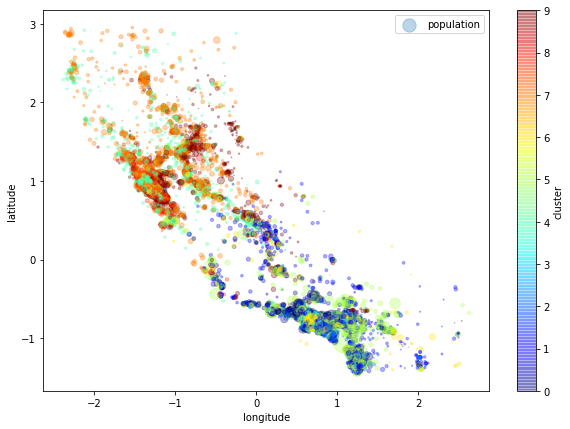

In [ ]:
# Iteration where k=10 and p=2
iter11 = K_means(k=10, p=2)
cluster, centroid = iter11.fit(housing_train_prepared)

iter11_sse = iter11.inertia(housing_train_prepared, cluster, centroid)

print("Iteration where k=10 and p=2")
print("\nIteration SSE: ", iter11_sse)
print("\nStandard deviations in clusters: \n", iter11.std_dev(housing_train_prepared, cluster, centroid))
print("\nCluster means (centroids): \n", centroid)

housing_kmean = np.c_[housing_train_prepared, cluster]

housing_kmean_dataframe = pd.DataFrame(housing_kmean, columns=['longitude', 'latitude', 'housing_median_age', 'total_rooms',
                                                              'total_bedrooms', 'population', 'households', 'median_income',
                                                              'median_house_value', 'ocean_proximity', 'rooms_per_household',
                                                              'bedrooms_per_room', 'population_per_household', 'a', 'b', 'c', 'd', 'e', 'f', 'g', 'cluster'])

housing_kmean_dataframe.plot(kind="scatter", x="longitude", y="latitude", alpha=0.3,
    s=housing["population"]/100, label="population", figsize=(10,7),
    c="cluster", cmap=plt.get_cmap("jet"), colorbar=True,
    sharex=False)
plt.legend()

K-means with k=10 and p=2 has produced a similar graph to k=9. It accomplishes what all of the previous iterations have been able to as well and concetrate these 5 areas: San Francisco, Sacramento, Fresno, L.A., and San Diego. The differnce here is that it created another group(red) which I believe is based on population.

Text(0, 0.5, 'Inertia (SSE)')

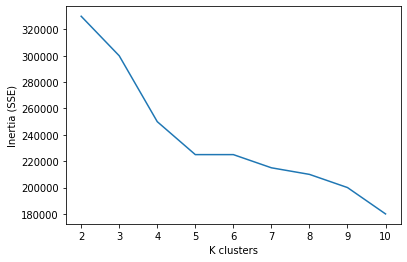

In [ ]:
plt.plot([2,3,4,5,6,7,8,9,10], [iter2_sse, iter4_sse, iter5_sse, iter6_sse, iter7_sse, iter8_sse, iter9_sse, iter10_sse, iter11_sse])
plt.xlabel("K clusters")
plt.ylabel("Inertia (SSE)")

From plotting each iterations SSE(inertia) I'm able to visualize the "elbow". I can see that the first concave curve starts at k=4. I would personally choose k=5 to be the optimal number of clusters since it's the sharpest "elbow" and the graph also appears to seperate the data better.

Iteration where k=5 and p=1

Iteration SSE:  231536.41640994838

Predicted values on test set: 
 [4. 4. 3. ... 4. 4. 4.]

Standard deviations in clusters: 
 [array([1.03126338, 0.70699416, 0.85745219, 0.4712672 , 0.56182765,
       0.4832656 , 0.54504183, 0.66749979, 1.18126179, 0.41506822,
       0.65884166, 2.6053178 , 0.41506822, 2.6053178 , 0.59502016,
       0.27729118, 0.6782831 , 0.        , 0.56143402, 0.26070944]), array([0.51248713, 0.55789228, 0.83121675, 0.48496693, 0.49953276,
       0.55788271, 0.53495351, 0.63418037, 0.88043847, 0.33203575,
       0.70742421, 0.09091799, 0.33203575, 0.09091799, 0.62874015,
       0.76019828, 0.40071478, 0.01993631, 0.        , 0.85957619]), array([0.52727533, 0.42577598, 0.82396461, 0.64488963, 0.95208978,
       1.23957182, 0.93613518, 0.61750565, 0.64162814, 0.34354592,
       1.19999139, 0.18050338, 0.34354592, 0.18050338, 1.47266544,
       0.46545556, 0.28975142, 0.01886121, 0.1333689 , 0.33845233]), array([0.94269081, 0.98426941, 1

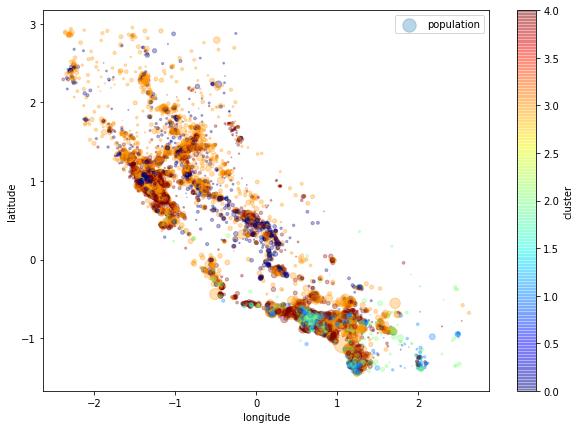

In [ ]:
# Iteration where k=5 and p=1
iter_5_1 = K_means(k=5, p=2)
cluster, centroid = iter_5_1.fit(housing_train_prepared)

iter_5_1_sse = iter_5_1.inertia(housing_train_prepared, cluster, centroid)
y_pred_1 = iter_5_1.predict(housing_test_prepared, centroid)

print("Iteration where k=5 and p=1")
print("\nIteration SSE: ", iter_5_1_sse)
print("\nPredicted values on test set: \n", y_pred_1)
print("\nStandard deviations in clusters: \n", iter_5_1.std_dev(housing_train_prepared, cluster, centroid))
print("\nCluster means (centroids): \n", centroid)

housing_kmean = np.c_[housing_train_prepared, cluster]

housing_kmean_dataframe = pd.DataFrame(housing_kmean, columns=['longitude', 'latitude', 'housing_median_age', 'total_rooms',
                                                              'total_bedrooms', 'population', 'households', 'median_income',
                                                              'median_house_value', 'ocean_proximity', 'rooms_per_household',
                                                              'bedrooms_per_room', 'population_per_household', 'a', 'b', 'c', 'd', 'e', 'f', 'g', 'cluster'])

housing_kmean_dataframe.plot(kind="scatter", x="longitude", y="latitude", alpha=0.3,
    s=housing["population"]/100, label="population", figsize=(10,7),
    c="cluster", cmap=plt.get_cmap("jet"), colorbar=True,
    sharex=False)
plt.legend()

Iteration where k=5 and p=2

Iteration SSE:  268043.3668474675

Predicted values on test set: 
 [4. 4. 4. ... 4. 4. 4.]

Standard deviations in clusters: 
 [array([0.47209744, 0.64051999, 1.52587297, 0.75766489, 0.96077064,
       0.81505135, 0.96758385, 0.69853806, 0.61769509, 0.52445118,
       1.42412988, 0.08824094, 0.52445118, 0.08824094, 1.70067207,
       0.30765274, 0.60669938, 0.        , 0.7554103 , 0.32849715]), array([1.00298297, 1.18101533, 0.6649873 , 2.14348873, 2.29730143,
       1.87777056, 2.24316015, 0.52499593, 0.79658376, 0.39113268,
       0.88635926, 2.56475092, 0.39113268, 2.56475092, 0.78589858,
       0.60628446, 0.55591929, 0.        , 0.12471827, 0.83197461]), array([0.68659215, 0.80298551, 0.83140834, 0.58823808, 0.8321466 ,
       0.69016136, 0.78143369, 0.3851641 , 0.54918224, 0.3542255 ,
       0.94698372, 0.11689804, 0.3542255 , 0.11689804, 0.86729817,
       0.59511406, 0.52405905, 0.02383318, 0.06741041, 0.27278321]), array([1.14759171, 0.9765525 , 0.

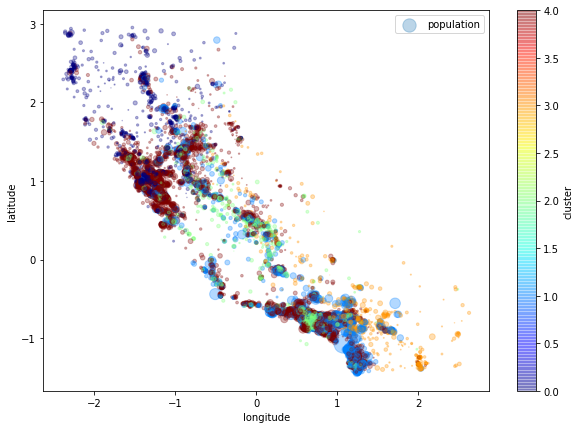

In [ ]:
# Iteration where k=5 and p=2
iter_5_2 = K_means(k=5, p=2)
cluster, centroid = iter_5_2.fit(housing_train_prepared)

iter_5_2_sse = iter_5_2.inertia(housing_train_prepared, cluster, centroid)
y_pred_2 = iter_5_2.predict(housing_test_prepared, centroid)

print("Iteration where k=5 and p=2")
print("\nIteration SSE: ", iter_5_2_sse)
print("\nPredicted values on test set: \n",y_pred_2)
print("\nStandard deviations in clusters: \n", iter_5_2.std_dev(housing_train_prepared, cluster, centroid))
print("\nCluster means (centroids): \n", centroid)


housing_kmean = np.c_[housing_train_prepared, cluster]

housing_kmean_dataframe = pd.DataFrame(housing_kmean, columns=['longitude', 'latitude', 'housing_median_age', 'total_rooms',
                                                              'total_bedrooms', 'population', 'households', 'median_income',
                                                              'median_house_value', 'ocean_proximity', 'rooms_per_household',
                                                              'bedrooms_per_room', 'population_per_household', 'a', 'b', 'c', 'd', 'e', 'f', 'g', 'cluster'])

housing_kmean_dataframe.plot(kind="scatter", x="longitude", y="latitude", alpha=0.3,
    s=housing["population"]/100, label="population", figsize=(10,7),
    c="cluster", cmap=plt.get_cmap("jet"), colorbar=True,
    sharex=False)
plt.legend()

Iteration where k=5 and p=infinity

Iteration SSE:  251757.7878342744

Predicted values on test set: 
 [4. 3. 1. ... 3. 0. 4.]

Standard deviations in clusters: 
 [array([0.80949927, 0.84675786, 0.83578345, 0.77866943, 0.79878573,
       0.74532304, 0.88213886, 0.66084015, 0.89093308, 0.67046687,
       0.66505627, 0.09440532, 0.67046687, 0.09440532, 0.59039077,
       0.37935918, 0.5445556 , 0.        , 0.30270325, 0.24697804]), array([0.79413105, 0.74955184, 0.95524987, 0.786221  , 0.89055673,
       1.03209211, 0.9268933 , 0.55315241, 0.92810234, 0.38180882,
       1.27871594, 0.13225886, 0.38180882, 0.13225886, 1.35594247,
       0.67494196, 0.48381907, 0.01415063, 0.23380676, 0.40816653]), array([0.6060332 , 0.71004298, 0.61016124, 0.83907987, 0.70404201,
       0.74213275, 0.74161741, 0.78022655, 0.76328769, 0.37135159,
       0.44678883, 4.91602295, 0.37135159, 4.91602295, 0.39013172,
       0.6493055 , 0.40703866, 0.        , 0.32861553, 0.38461538]), array([1.10097546, 0.95251

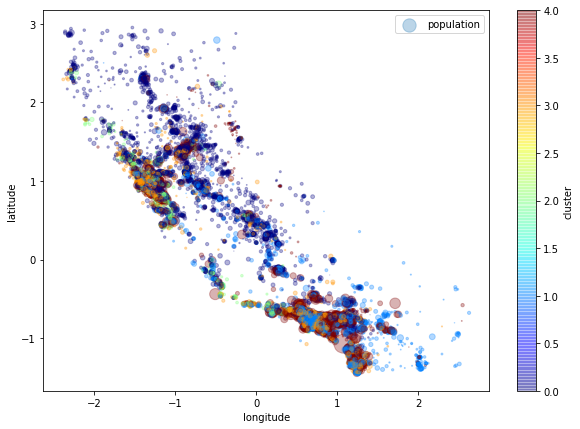

In [ ]:
# Iteration where k=5 and p=infinity
iter_5_i = K_means(k=5, p=np.inf)
cluster, centroid = iter_5_i.fit(housing_train_prepared)

iter_5_i_sse = iter_5_i.inertia(housing_train_prepared, cluster, centroid)
y_pred_i = iter_5_i.predict(housing_test_prepared, centroid)

print("Iteration where k=5 and p=infinity")
print("\nIteration SSE: ", iter_5_i_sse)
print("\nPredicted values on test set: \n", y_pred_i)
print("\nStandard deviations in clusters: \n", iter_5_i.std_dev(housing_train_prepared, cluster, centroid))
print("\nCluster means (centroids): \n", centroid)

housing_kmean = np.c_[housing_train_prepared, cluster]

housing_kmean_dataframe = pd.DataFrame(housing_kmean, columns=['longitude', 'latitude', 'housing_median_age', 'total_rooms',
                                                              'total_bedrooms', 'population', 'households', 'median_income',
                                                              'median_house_value', 'ocean_proximity', 'rooms_per_household',
                                                              'bedrooms_per_room', 'population_per_household', 'a', 'b', 'c', 'd', 'e', 'f', 'g', 'cluster'])

housing_kmean_dataframe.plot(kind="scatter", x="longitude", y="latitude", alpha=0.3,
    s=housing["population"]/100, label="population", figsize=(10,7),
    c="cluster", cmap=plt.get_cmap("jet"), colorbar=True,
    sharex=False)
plt.legend()

After testing the clustering with my chosen optimal k=5 on every p, I'm quite happy with how it turns out. It basically pulls out the 5 large cities in California, but doesn't create uneccessary groups. Thus, I'm even more sure the k=5 is optimal.

- - -
## 4. WRITING ON THE INTUITION FOR THE CALIFORNIA HOUSING CRISIS (10 pts)

This question is a qualitative one, and is intended to let you experiment with a real world clustering task. Hopefully it gives you some intuition as for how the preset number of clusters affects the clustering results. Too few clusters may not reveal the information that is in the data. Too many clusters may hurt data analysis as well, as it may not generalize (and in this sense, it is equivalent to over fitting).

Write at least one paragraph to demonstrate your intuition on the California Housing Crisis. You might also want to mention some possible solutions to solve it. You will receive credits based upon your insights and intuitions on this challenge. 



Going through the California housing data set was quite intriguing. Analyzing the correlations gave me specific statistics and implementing K-means clustering which was able to find patterns in the data was enlightening. This unsupervised algorithm did really well, it split the way I was expecting and was efficient for the amount of data it was operating on. The California housing crisis is a very complex issue and one man won't be able to solve it. Based on my observations it appears that there are a handful of areas in California that are very expensive. These areas may lead to a bias of the amount and type of people that live there. This is because it is fiscally impossible for some to pay for even one bedroom apartments, let alone houses. This excludes many groups of people and causes disproportianate employment and services from big businesses. A potential solution could be to try and break up these high concentration areas. While areas like Silicon Valley, San Francisco and L.A. spark competition and drive innovation, I think that if you provided incentives else where it would drive the same innovation and creativity without congesting areas. This would cause housing prices to go down since there are less people and thus less demand for living quarters and general goods such as groceries and parking. The state of California is in a hard situation, it homes some of the greatest inventions of the 21st century, but this success needs to be felt by the citizens of the state. Something must be done to make the choice of living equitable for the people of California. 

- - - 
### NEED HELP?

In case you get stuck in any step in the process, you may find some useful information from:

 * Consult my lectures and/or the textbook
 * Talk to the TA, they are available and there to help you during their OH.
 * Come talk to me or email me <nn4pj@virginia.edu> with subject starting "CS4774 Assignment 3:...".

Best of luck and have fun!